In [ ]:
### March 2024
### Skylar Fang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from bagpy import bagreader
import os
from PyPDF2 import PdfMerger
import plotly.express as px # for 2D heatmap
import seaborn as sns # for 2D heatmap
import logging
from dotenv import dotenv_values
from scipy.stats import sem
import random
import scipy.stats
from helpers import *
#from helpers_2 import *
#from plot_helpers import *
#from plot_helpers_BNS_Nov2023 import*
#from plot_helpers_CIHR_Feb2024 import *
from signal_processing import *

%load_ext autoreload
%autoreload 2

logger = logging.getLogger(__name__)
FORMAT = "[%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s"
logging.basicConfig(level=logging.INFO, format=FORMAT) # This alone would not set level properly
logging.getLogger().setLevel(logging.INFO)

config = dotenv_values()
os.environ['PATH'] += os.pathsep + config['SPIKEGADGETS_PATH']
# os.environ['CUDA_PATH'] = config['CUDA_PATH']
os.environ['NC4_DATA_DIR'] = config['NC4_DATA_DIR']

In [2]:
rat = 10
date = '230507'
session_folder = get_session_folder(os.environ['NC4_DATA_DIR'], rat, date)
get_experiment_vars_df(session_folder)

[helpers.py:43 -      get_anim_folder() ] Animal folder located at \\10.34.1.59\lil_swallow\NC40010
[helpers.py:33 -   get_session_folder() ] Session folder located at \\10.34.1.59\lil_swallow\NC40010\230507_training
[helpers.py:457 - get_experiment_vars_df() ] experimental_vars pkl file found at \\10.34.1.59\lil_swallow\NC40010\230507_training\extracted\experiment_vars.pkl


,Time,boomAngle,ratAngle,soundFrequency,soundGain,landmarksGain,soundPhase,commutationMode,modulationMode,soundCheck,probe,landmarkAngle,domeVisible,rewardButton
0,1.683508e+09,1087.972955,12.640661,2903.0,0.736842,0.0,13.368210,marker,boomer,True,0,0.0,no,0
1,1.683508e+09,1087.972955,12.707501,2903.0,0.736842,0.0,13.368210,marker,boomer,True,0,0.0,no,0
2,1.683508e+09,1087.972775,12.707501,2903.0,0.736842,0.0,13.368207,marker,boomer,True,0,0.0,no,0
3,1.683508e+09,1087.972955,12.684971,2903.0,0.736842,0.0,13.368210,marker,boomer,True,0,0.0,no,0
4,1.683508e+09,1087.972955,12.684971,2903.0,0.736842,0.0,13.368210,marker,boomer,True,0,0.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140789,1.683509e+09,18328.264337,-26.609956,8630.0,0.886840,0.0,234.885178,marker,boomer,False,2,0.0,no,0
140790,1.683509e+09,18328.263977,-26.609956,8630.0,0.886840,0.0,234.885173,marker,boomer,False,2,0.0,no,0
140791,1.683509e+09,18328.263977,-26.713260,8630.0,0.886840,0.0,234.885173,marker,boomer,False,2,0.0,no,0
140792,1.683509e+09,18328.263977,-26.713260,8630.0,0.886840,0.0,234.885173,marker,boomer,False,2,0.0,no,0


Prepare data to share with the Miolane Lab. One dataframe for each autocurated and visually examined unit. Dataframe includes spike time (in sec, zeroed with first timestamp of ROS recording), rat angle in lab frame, rat angle in sound frame (sound degree), sound frequency,  in a reward zone or not, rat angle in the landmark frame (rat angle with regards to the landmarks), sound gain and landmark gain, FS order (sound modulation smoothing with Fourier series parameter). Trodes and ROS timestamps are aligned with sync messages.

In [3]:
rat = 10
mts_vers = 'mts4'
scheme = None
date = '230406'
session_folder = get_session_folder(os.environ['NC4_DATA_DIR'], rat, date)

[helpers.py:43 -      get_anim_folder() ] Animal folder located at \\10.34.1.59\lil_swallow\NC40010
[helpers.py:33 -   get_session_folder() ] Session folder located at \\10.34.1.59\lil_swallow\NC40010\230406_training


In [4]:
# Get Spikegadgets timestamps
time_dict = read_timestamps_dat(session_folder, skip_timestamps = False)
#system_time_at_creation = time_dict['systime_creation']
#spikegadgets_timestamp_at_creation = time_dict['spikegadgets_timestamp_creation']
spikegadgets_timestamps = time_dict['spikegadgets_timestamps']

[helpers.py:518 -   get_timestamps_dat() ] merged_time folder found at \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\230406_merged.time


b'<Start settings>'
b'Description: Timestamps'
b'Byte_order: little endian'
b'Original_file: 230406_merged.rec'
b'Clockrate: 30000'
b'Trodes_version: 2.3.4'
b'Compile_date: Nov 28 2022'
b'Compile_time: 15:10:45'
b'QT_version: 6.2.2'
b'Commit_tag: heads/Release_2.3.4-0-gd5a58cd9-dirty'
b'Controller_firmware: 3.18'
b'Headstage_firmware: 4.4'
b'Controller_serialnum: 00104 00163'
b'Headstage_serialnum: 00407 00129'
b'AutoSettle: 0'
b'SmartRef: 0'
b'Gyro: 0'
b'Accelerometer: 0'
b'Magnetometer: 1'
b'Time_offset: 0'
b'System_time_at_creation: 1680815387037'
System time at creation:1680815387037
b'Timestamp_at_creation: 81963'
SpikeGadgets timestamp at creation:81963
b'First_timestamp: 132054'
SpikeGadgets first timestamp:132054
b'Decimation: 20'
b'Fields: <time uint32><systime int64>'
b'<End settings>'


In [14]:
trodes_sync_timestamps = load_trodes_sync_ts_array(session_folder)
ros_sync_timestamps = load_ros_sync_ts_array(session_folder)

[helpers.py:730 - load_trodes_sync_ts_array() ] Loading \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\Trodes_sync_timestamps.npy
[helpers.py:747 - load_ros_sync_ts_array() ] Loading \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\ROS_sync_timestamps.npy


In [16]:
## Sync timestamps
#p = np.polyfit(x_match, y_match, 1)
new_p, trodes_sync_ts_match, ros_sync_ts_match = align_timestamps_nw(trodes_sync_timestamps,
                                                                     ros_sync_timestamps, new = True)

[signal_processing.py:115 -  align_timestamps_nw() ] Aligning timestamps of length 124 and 126
[signal_processing.py:185 -  align_timestamps_nw() ] Found 123 matching timestamps


[383152312.py:5 -             <module>() ] Drift: -0.449828 s over 1220.104016 s, 1000383.823859 us/s


Text(0, 0.5, 'Deviation (s)')

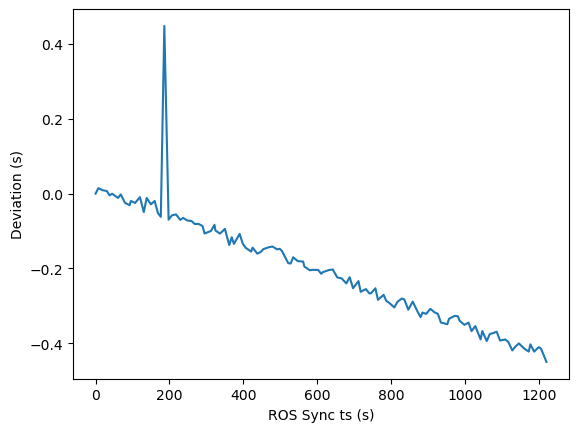

In [18]:
dev_match = trodes_sync_ts_match-ros_sync_ts_match

rts_match = ros_sync_ts_match-ros_sync_ts_match[0]
dev_match = dev_match-dev_match[0]
logger.info('Drift: %f s over %f s, %f us/s', dev_match[-1], rts_match[-1], new_p[0]*1.0e6)

plt.plot(rts_match, dev_match - dev_match[0])
# plt.plot(rts_match, rts_match[0]+np.polyval(p, rts_match), '--g')
plt.xlabel('ROS Sync ts (s)')
plt.ylabel('Deviation (s)')

In [6]:
experiment_vars = get_experiment_vars_df(session_folder)
ros_timestamps = experiment_vars['Time'] # in system time

[helpers.py:457 - get_experiment_vars_df() ] experimental_vars pkl file found at \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\experiment_vars.pkl


In [19]:
get_autocurated_unit_ids_df(session_folder, mts_vers, scheme)

,Tetrode,Autocurated_unit_ids
0,1,[5]
1,2,"[2, 4]"
2,4,"[1, 2]"
3,5,[]
4,6,"[5, 8]"
5,8,"[3, 6]"
6,9,[6]
7,15,"[3, 4, 5]"
8,18,"[5, 10]"
9,22,"[2, 10]"


In [ ]:
pd.read_excel()

In [22]:
# unit_index starts from 1
unit_timestamps = get_mts_unit_timestamps(session_folder, mts_vers, scheme, tetrode=1, unit_index=1, 
                                            autocurated=True, spikegadgets_timestamps=spikegadgets_timestamps)
unit_timestamps_sec = unit_timestamps / 30000

[helpers.py:607 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT1.npy


In [24]:
unit_timestamps_sec

array([  16.87583333,   16.99796667,   17.11943333, ..., 1249.30093333,
       1249.46273333, 1249.59696667])

In [34]:
# new_p = np.polyfit(x_match, y_match, 1)
new_unit_timestamps_in_ros_time = np.polyval(new_p, unit_timestamps_sec)

In [35]:
new_unit_timestamps_in_ros_time

array([1.68081540e+09, 1.68081540e+09, 1.68081540e+09, ...,
       1.68081663e+09, 1.68081663e+09, 1.68081663e+09])

In [30]:
spike_timestamps_aligned = (unit_timestamps - time_dict['spikegadgets_timestamp_creation']) / 30000

In [31]:
spike_timestamps_aligned

array([  14.14373333,   14.26586667,   14.38733333, ..., 1246.56883333,
       1246.73063333, 1246.86486667])

In [36]:
spike_ts_dev = (new_unit_timestamps_in_ros_time - ros_timestamps[0]) - spike_timestamps_aligned

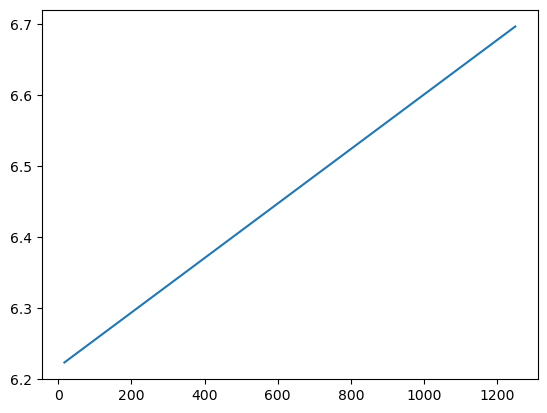

In [37]:
plt.plot(unit_timestamps_sec, spike_ts_dev)

In [90]:
ros_ratAngle = np.unwrap(experiment_vars['ratAngle'] + 180, period=360)
ros_soundDegree = experiment_vars['soundPhase']/np.pi*180
ros_soundFrequency = experiment_vars['soundFrequency']
ros_landmarkAngle = experiment_vars['landmarkAngle']
ros_ratAngle_landmark = get_new_ratAngle_landmark(ros_ratAngle, ros_landmarkAngle) # in range 0-360
ros_sound_gain = experiment_vars['soundGain']

if date <= '240119':
    # Dome code edited after session 240119 so that default landmark gain is 1 for later sessions
    ros_landmark_gain = 1 - experiment_vars['landmarksGain']

ros_in_rewardZone = experiment_vars['soundCheck']

In [91]:
unit_ratAngle_lab = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_ratAngle)
unit_ratAngle_lab = unit_ratAngle_lab % 360
unit_ratAngle_sound = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_soundDegree)
unit_ratAngle_sound = unit_ratAngle_sound % 360
unit_sound_frequency = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_soundFrequency)
unit_in_rewardZone = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_in_rewardZone)
unit_in_rewardZone = [bool(x) for x in unit_in_rewardZone]
unit_ratAngle_landmark = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_ratAngle_landmark)
unit_sound_gain = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_sound_gain)
unit_landmark_gain = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_landmark_gain)
unit_FSorder = ["N/A" for _ in range(len(new_unit_timestamps_in_ros_time))] # 240406

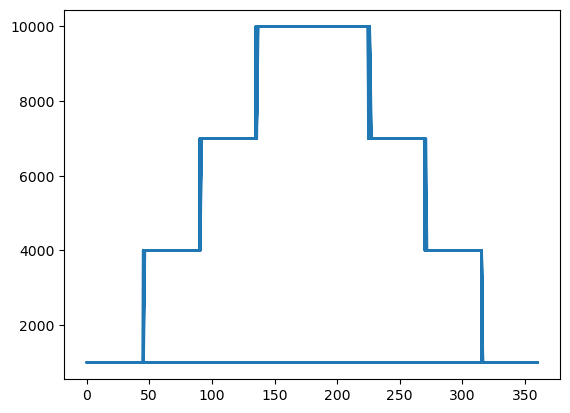

In [50]:
plt.plot(experiment_vars['soundPhase']/math.pi*180 %360, experiment_vars['soundFrequency'])

In [92]:
new_unit_timestamps_in_ros_time_zeroed = new_unit_timestamps_in_ros_time - ros_timestamps[0]

In [93]:
d = {'time': new_unit_timestamps_in_ros_time_zeroed,
     'angle_lab': unit_ratAngle_lab,
     'angle_sound': unit_ratAngle_sound,
     'unit_sound_frequency': unit_sound_frequency,
     'in_reward_zone': unit_in_rewardZone,
     'angle_landmark': unit_ratAngle_landmark,
     'sound_gain': unit_sound_gain,
     'landmark_gain': unit_landmark_gain,
     'FS_order': unit_FSorder}
df = pd.DataFrame(data=d)

In [94]:
df

,time,angle_lab,angle_sound,unit_sound_frequency,in_reward_zone,angle_landmark,sound_gain,landmark_gain,FS_order
0,20.367333,201.856723,273.393962,4000.0,True,220.408509,0.73684,0.95,N/A
1,20.489513,201.799125,273.393962,4000.0,True,220.350912,0.73684,0.95,N/A
2,20.611026,201.704541,273.393962,4000.0,True,220.256327,0.73684,0.95,N/A
3,20.736241,201.897475,273.393962,4000.0,True,220.449261,0.73684,0.95,N/A
4,20.994907,201.834320,273.393962,4000.0,True,220.386106,0.73684,0.95,N/A
...,...,...,...,...,...,...,...,...,...
1074,1253.004233,32.653839,280.991819,4000.0,True,186.723638,0.73684,0.95,N/A
1075,1253.132883,32.600678,280.991780,4000.0,True,186.670475,0.73684,0.95,N/A
1076,1253.265467,32.590088,280.991819,4000.0,True,186.659887,0.73684,0.95,N/A
1077,1253.427329,32.579463,280.991686,4000.0,True,186.649253,0.73684,0.95,N/A


In [95]:
df_save_path = 'C:/Files/NC4/data_ana_lab/data_sharing/NC40010'

In [96]:
df_save_session_path = os.path.join(df_save_path, date)
if not os.path.isdir(df_save_session_path):
    os.mkdir(df_save_session_path)

In [97]:
tetrode = 1
unit_index = 1 
# unit index start with 1. If the unit's id is 5 but is the only one got through autocuration
# and visual examination, its unit_index here should be 1

In [98]:
df.to_pickle(os.path.join(df_save_session_path, 'session%s_tetrode%d_unit_index%d' % (date, tetrode, unit_index)))

In [99]:
pd.read_pickle(os.path.join(df_save_session_path, 'session%s_tetrode%d_unit_index%d' % (date, tetrode, unit_index)))

,time,angle_lab,angle_sound,unit_sound_frequency,in_reward_zone,angle_landmark,sound_gain,landmark_gain,FS_order
0,20.367333,201.856723,273.393962,4000.0,True,220.408509,0.73684,0.95,N/A
1,20.489513,201.799125,273.393962,4000.0,True,220.350912,0.73684,0.95,N/A
2,20.611026,201.704541,273.393962,4000.0,True,220.256327,0.73684,0.95,N/A
3,20.736241,201.897475,273.393962,4000.0,True,220.449261,0.73684,0.95,N/A
4,20.994907,201.834320,273.393962,4000.0,True,220.386106,0.73684,0.95,N/A
...,...,...,...,...,...,...,...,...,...
1074,1253.004233,32.653839,280.991819,4000.0,True,186.723638,0.73684,0.95,N/A
1075,1253.132883,32.600678,280.991780,4000.0,True,186.670475,0.73684,0.95,N/A
1076,1253.265467,32.590088,280.991819,4000.0,True,186.659887,0.73684,0.95,N/A
1077,1253.427329,32.579463,280.991686,4000.0,True,186.649253,0.73684,0.95,N/A


For one session

In [13]:
rat = 10
mts_vers = 'mts4'
scheme = None
date = '230507'
df_save_path = 'C:/Files/NC4/data_ana_lab/data_sharing/NC40010'
df_save_session_path = os.path.join(df_save_path, date)
if not os.path.isdir(df_save_session_path):
    os.mkdir(df_save_session_path)
session_folder = get_session_folder(os.environ['NC4_DATA_DIR'], rat, date)

autocurated_unit_ids_df = get_autocurated_unit_ids_df(session_folder, mts_vers, scheme)
visually_excluded_unit_ids = get_visually_excluded_unit_ids_df(session_folder, mts_vers, scheme)

# Get Spikegadgets timestamps
time_dict = read_timestamps_dat(session_folder, skip_timestamps = False)
spikegadgets_timestamps = time_dict['spikegadgets_timestamps']

[helpers.py:43 -      get_anim_folder() ] Animal folder located at \\10.34.1.59\lil_swallow\NC40010
[helpers.py:33 -   get_session_folder() ] Session folder located at \\10.34.1.59\lil_swallow\NC40010\230507_training
[helpers.py:554 -   get_timestamps_dat() ] merged_time folder found at \\10.34.1.59\lil_swallow\NC40010\230507_training\extracted\230507_merged.time


b'<Start settings>'
b'Description: Timestamps'
b'Byte_order: little endian'
b'Original_file: 230507_merged.rec'
b'Clockrate: 30000'
b'Trodes_version: 2.3.4'
b'Compile_date: Nov 28 2022'
b'Compile_time: 15:10:45'
b'QT_version: 6.2.2'
b'Commit_tag: heads/Release_2.3.4-0-gd5a58cd9-dirty'
b'Controller_firmware: 3.18'
b'Headstage_firmware: 4.4'
b'Controller_serialnum: 00104 00163'
b'Headstage_serialnum: 00407 00129'
b'AutoSettle: 0'
b'SmartRef: 0'
b'Gyro: 0'
b'Accelerometer: 0'
b'Magnetometer: 1'
b'Time_offset: 0'
b'System_time_at_creation: 1683507827830'
System time at creation:1683507827830
b'Timestamp_at_creation: 77409'
SpikeGadgets timestamp at creation:77409
b'First_timestamp: 91072'
SpikeGadgets first timestamp:91072
b'Decimation: 20'
b'Fields: <time uint32><systime int64>'
b'<End settings>'


[helpers.py:766 - load_trodes_sync_ts_array() ] Loading \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\Trodes_sync_timestamps.npy
[helpers.py:783 - load_ros_sync_ts_array() ] Loading \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\ROS_sync_timestamps.npy
[signal_processing.py:115 -  align_timestamps_nw() ] Aligning timestamps of length 124 and 126
[signal_processing.py:185 -  align_timestamps_nw() ] Found 123 matching timestamps
[2720858388.py:12 -             <module>() ] Drift: -0.449828 s over 1220.104016 s, 1000383.823859 us/s


Text(0, 0.5, 'Deviation (s)')

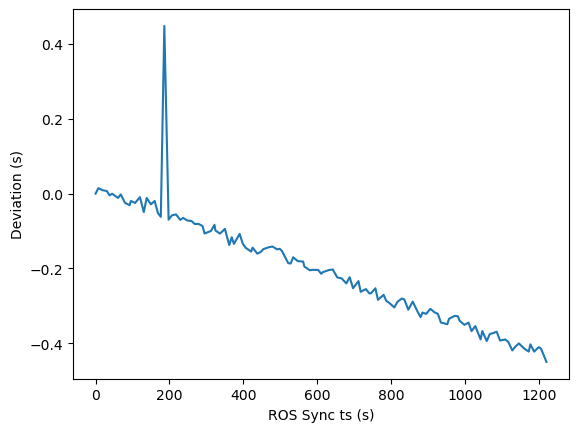

In [3]:
trodes_sync_timestamps = load_trodes_sync_ts_array(session_folder)
ros_sync_timestamps = load_ros_sync_ts_array(session_folder)
## Sync timestamps
#p = np.polyfit(x_match, y_match, 1)
new_p, trodes_sync_ts_match, ros_sync_ts_match = align_timestamps_nw(trodes_sync_timestamps,
                                                                     ros_sync_timestamps, new = True)

dev_match = trodes_sync_ts_match-ros_sync_ts_match

rts_match = ros_sync_ts_match-ros_sync_ts_match[0]
dev_match = dev_match-dev_match[0]
logger.info('Drift: %f s over %f s, %f us/s', dev_match[-1], rts_match[-1], new_p[0]*1.0e6)

plt.plot(rts_match, dev_match - dev_match[0])
# plt.plot(rts_match, rts_match[0]+np.polyval(p, rts_match), '--g')
plt.xlabel('ROS Sync ts (s)')
plt.ylabel('Deviation (s)')

In [4]:
experiment_vars = get_experiment_vars_df(session_folder)
ros_timestamps = experiment_vars['Time'] # in system time

ros_ratAngle = np.unwrap(experiment_vars['ratAngle'] + 180, period=360)
ros_soundDegree = experiment_vars['soundPhase']/np.pi*180
ros_soundFrequency = experiment_vars['soundFrequency']
ros_landmarkAngle = experiment_vars['landmarkAngle']
ros_ratAngle_landmark = get_new_ratAngle_landmark(ros_ratAngle, ros_landmarkAngle) # in range 0-360
ros_sound_gain = experiment_vars['soundGain']

if date <= '240119':
    # Dome code edited after session 240119 so that default landmark gain is 1 for later sessions
    ros_landmark_gain = 1 - experiment_vars['landmarksGain']

ros_in_rewardZone = experiment_vars['soundCheck']

[helpers.py:493 - get_experiment_vars_df() ] experimental_vars pkl file found at \\10.34.1.59\lil_swallow\NC40010\230406_training\extracted\experiment_vars.pkl


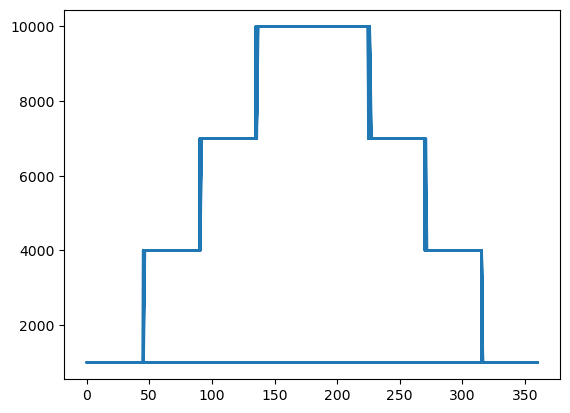

In [5]:
plt.plot(experiment_vars['soundPhase']/math.pi*180 %360, experiment_vars['soundFrequency'])

In [6]:
partial_excluded_tt = visually_excluded_unit_ids['tetrode'].to_numpy()
cnt = 0
for i in range(autocurated_unit_ids_df.shape[0]):
    tetrode = autocurated_unit_ids_df['Tetrode'][i]
    autocurated_unit_ids = autocurated_unit_ids_df['Autocurated_unit_ids'][i]
    num_autocurated_unit = len(autocurated_unit_ids)
    if num_autocurated_unit > 0:
        for i in range(num_autocurated_unit):
            if tetrode in partial_excluded_tt:
                # Below are the visually exclude unit ids on the specifc tetrode
                tt_excluded_unit_ids = visually_excluded_unit_ids[visually_excluded_unit_ids['tetrode']==tetrode]['excluded_unit_ids'].to_numpy()[0]
                if autocurated_unit_ids[i] in tt_excluded_unit_ids:
                    continue
            
            print(tetrode, autocurated_unit_ids[i])
            cnt+=1
            unit_timestamps = get_mts_unit_timestamps(session_folder, mts_vers, scheme, tetrode, unit_index=i+1, 
                                            autocurated=True, spikegadgets_timestamps=spikegadgets_timestamps)
            unit_timestamps_sec = unit_timestamps / 30000

            # new_p = np.polyfit(x_match, y_match, 1)
            new_unit_timestamps_in_ros_time = np.polyval(new_p, unit_timestamps_sec)

            unit_ratAngle_lab = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_ratAngle)
            unit_ratAngle_lab = unit_ratAngle_lab % 360
            unit_ratAngle_sound = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_soundDegree)
            unit_ratAngle_sound = unit_ratAngle_sound % 360
            unit_sound_frequency = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_soundFrequency)
            unit_in_rewardZone = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_in_rewardZone)
            unit_in_rewardZone = [bool(x) for x in unit_in_rewardZone]
            unit_ratAngle_landmark = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_ratAngle_landmark)
            unit_sound_gain = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_sound_gain)
            unit_landmark_gain = np.interp(new_unit_timestamps_in_ros_time, ros_timestamps, ros_landmark_gain)
            unit_FSorder = ["N/A" for _ in range(len(new_unit_timestamps_in_ros_time))] # 240426

            new_unit_timestamps_in_ros_time_zeroed = new_unit_timestamps_in_ros_time - ros_timestamps[0]
            d = {'time': new_unit_timestamps_in_ros_time_zeroed,
                'angle_lab': unit_ratAngle_lab,
                'angle_sound': unit_ratAngle_sound,
                'unit_sound_frequency': unit_sound_frequency,
                'in_reward_zone': unit_in_rewardZone,
                'angle_landmark': unit_ratAngle_landmark,
                'sound_gain': unit_sound_gain,
                'landmark_gain': unit_landmark_gain,
                'FS_order': unit_FSorder}
            df = pd.DataFrame(data=d)
            df.to_pickle(os.path.join(df_save_session_path, 'session%s_tetrode%d_unit_id%d.pkl' % (date, tetrode, autocurated_unit_ids[i])))


        


[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT1.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT2.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT2.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT4.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT4.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT6.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\

1 5
2 2
2 4
4 1
4 2
6 5
6 8
9 6


[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT15.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT15.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT15.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT18.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT22.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT24.npy
[helpers.py:643 -           get_mts_df() ] Loa

15 3
15 4
15 5
18 5
22 2
24 1
24 2
24 5


[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT25.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT25.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT27.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT27.npy
[helpers.py:643 -           get_mts_df() ] Loaded \\10.34.1.59\lil_swallow\NC40010\230406_training\sorting\mts4\spike_vector_autocurated\spike_vector_TT27.npy


25 11
25 12
27 3
27 7
27 9


In [7]:
cnt

21

In [8]:
get_num_autocurated_units(session_folder, mts_vers, scheme)

21

In [40]:
get_visually_excluded_unit_ids_df(session_folder, mts_vers, scheme)

,tetrode,excluded_unit_ids
0,16,[2]
1,29,[5]


In [14]:
df = pd.read_pickle(os.path.join(df_save_session_path, 'session%s_tetrode%d_unit_id%d.pkl' % (date, 29, 2)))

In [15]:
df

,time,angle_lab,angle_sound,unit_sound_frequency,in_reward_zone,angle_landmark,sound_gain,landmark_gain,FS_order
0,5.848460,291.736282,114.255968,7125.151965,False,291.736282,0.736842,1.0,8
1,7.634311,328.839901,147.002418,9893.000000,False,328.839901,0.736842,1.0,8
2,17.902024,133.111206,263.347142,6356.814861,False,133.111206,0.736842,1.0,8
3,19.271156,146.332600,277.826458,4539.000000,True,146.332600,0.736842,1.0,8
4,19.517513,147.688491,277.824631,4539.000000,True,147.688491,0.736842,1.0,8
...,...,...,...,...,...,...,...,...,...
1525,1357.929357,74.173888,67.807215,3873.000000,True,74.173888,0.886840,1.0,8
1526,1358.538679,74.425264,67.807225,3873.000000,True,74.425264,0.886840,1.0,8
1527,1358.680531,74.436637,67.807225,3873.000000,True,74.436637,0.886840,1.0,8
1528,1358.876702,74.345535,67.807225,3873.000000,True,74.345535,0.886840,1.0,8


In [44]:
df.shape

(1530, 9)

In [45]:
sum(df['in_reward_zone'])

1178